# 4.32 (TM) Part C

This notebook integrates the unsteady mass and energy balances for a rigid 10 m³ chamber being evacuated by a rotary vacuum pump with a small heat leak and a tiny air leak. It also computes the minimum pump power (adiabatic reversible compressor corrected by efficiency) and separates the plots into individual figures.

## Assumptions
- Ideal gas air, constant heat capacities ($C_p, C_v$)
- Rigid chamber ($V=\text{const}$)
- Heat leak into chamber $\dot q_{\text{leak}}$ (constant)
- Tiny air leak in at $T_\text{amb}=300\,\mathrm{K}$ with molar flow $\dot N_{\text{leak}}$ (constant)
- Pump removes moles at $\dot N_{\text{pump}}=\dfrac{P\,\dot V_{\text{pump}}}{R\,T}$ (evaluated at chamber state)
- Minimum power equals reversible adiabatic compression from chamber pressure $P$ to ambient/exhaust $P_a$, corrected by efficiency $\eta$:  
$$\dot W=\frac{\dot N_{\text{pump}}}{\eta} C_p T\left[\left(\frac{P_a}{P}\right)^{(\gamma-1)/\gamma}-1\right],\quad \gamma=C_p/C_v.$$


In [1]:
using DifferentialEquations, Trapz
using Plots, LaTeXStrings
default(size=(900,520), legend=:topright, 
        fontfamily="Computer Modern", lw=2, margins=5Plots.mm)

In [2]:
## Parameters
V      = 10.0            # m^3 (rigid chamber)
qdot   = 10.0            # J/s (heat leak into chamber)
Nleak  = 1e-7            # mol/s (air leak in)
Vdot   = 1e-3            # m^3/s (pump volumetric displacement at inlet)
η      = 0.80            # pump efficiency
R      = 8.314           # J/mol/K
Cp     = 29.0            # J/mol/K
Cv     = Cp - R          # J/mol/K
γ      = Cp/Cv

Tamb   = 300.0           # K (ambient/leak temperature)
Pa     = 1.01e5          # Pa (ambient/exhaust pressure)
P0     = 1.01e5          # Pa (initial chamber pressure)
T0     = 300.0           # K (initial chamber temperature)
Ptarget = 1.0e4          # Pa (0.1 bar target)

# Initial moles from ideal gas
N0 = P0*V/(R*T0)

404.9394595461471

In [ ]:
## Helper functions
P_of(N,T) = N*R*T/V
Ndotpump(N,T) = P_of(N,T)*Vdot/(R*T)  # mol/s removed by pump

function pump_power(N,T)
    P = P_of(N,T)
    Ndot = Ndotpump(N,T)
    ratio = max(Pa/P, 1.0 + 1e-12) # avoid negative when P≈Pa
    wrev_per_mol = Cp*T*((ratio)^((γ-1)/γ) - 1.0)  # J/mol
    return (Ndot * wrev_per_mol) / η               # W
end

In [ ]:
## Governing ODEs: u = [N, T]
function chamber_odes!(du,u,p,t)
    N, T = u
    Ndot_p = Ndotpump(N,T)
    # Mass balance
    du[1] = Nleak - Ndot_p
    # Energy balance: 
    # Cv*(N dT/dt + T dN/dt) = qdot + Nleak*Cp*Tamb - Ndot_p*Cp*T
    rhs = qdot + Nleak*Cp*Tamb - Ndot_p*Cp*T
    dT  = (rhs/Cv - T*du[1]) / N
    du[2] = dT
end

# when this crosses zero, we hit target pressure
condition(u,t,integrator) = P_of(u[1],u[2]) - Ptarget 
# stop integration
affect!(integrator) = terminate!(integrator) 
# create callback for solver to handle event
cb = ContinuousCallback(condition, affect!; rootfind=true)

In [ ]:
## Integrate
u0    = [N0, T0]
tspan = (0.0, 24*3600.0)
prob  = ODEProblem(chamber_odes!, u0, tspan)
sol   = solve(prob, Tsit5(); 
              reltol=1e-8, abstol=1e-10, callback=cb, saveat=5.0)

t  = sol.t
N  = sol[1,:]
T  = sol[2,:]
P  = P_of.(N,T)
W  = pump_power.(N,T)

In [6]:
E  = trapz(t, W)                 # J
hit_target = P[end] ≤ Ptarget + 1e-6
ttarget = t[end]
@info "Reached target?" hit_target
@info "Time to target (s)" ttarget
@info "Time to target (h)" ttarget/3600
@info "Final temperature (K)" T[end]
@info "Final moles (mol)" N[end]
@info "Energy consumed (Wh)" E/3600
@info "Energy consumed (MJ)" E/1e6

┌ Info: Reached target?
│   hit_target = true
└ @ Main /Users/rafif/Documents/Purdue First Year/gradcourses/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:4
┌ Info: Time to target (s)
│   ttarget = 18700.22085948735
└ @ Main /Users/rafif/Documents/Purdue First Year/gradcourses/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:5
┌ Info: Time to target (h)
│   ttarget / 3600 = 5.194505794302041
└ @ Main /Users/rafif/Documents/Purdue First Year/gradcourses/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:6
┌ Info: Final temperature (K)
│   T[end] = 192.7233195288412
└ @ Main /Users/rafif/Documents/Purdue First Year/gradcourses/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:7
┌ Info: Final moles (mol)
│   N[end] = 62.410219834317914
└ @ Main /Users/rafif/Documents/Purdue First Year/gradcourses/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X25sZmlsZQ==.jl:8
┌ Info: Energy consumed (Wh)
│   E / 3600 = 230.711067810335

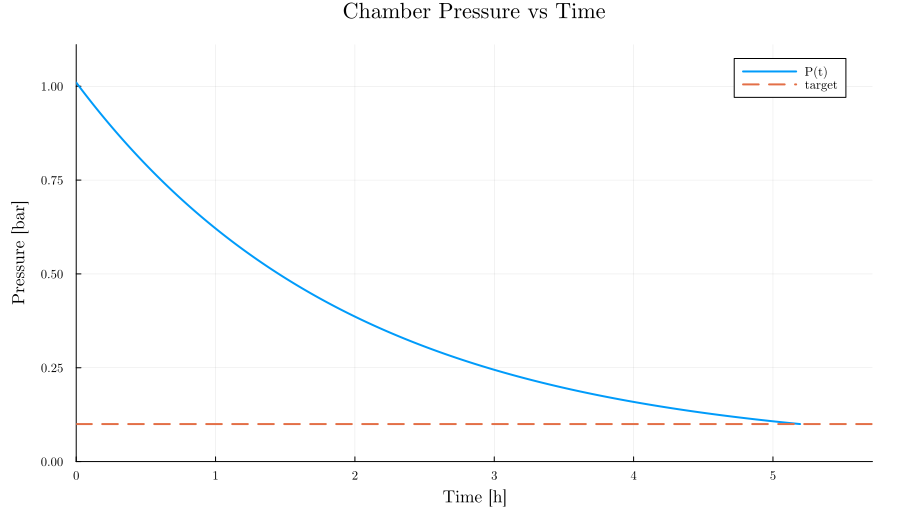

In [7]:
plot(t/3600, P./1e5, xlabel="Time [h]", ylabel="Pressure [bar]", 
     title="Chamber Pressure vs Time", label="P(t)", 
     xlims=(0, ttarget/3600*1.1), ylims=(0, P0/1e5*1.1))
hline!([Ptarget/1e5], ls=:dash, label="target")

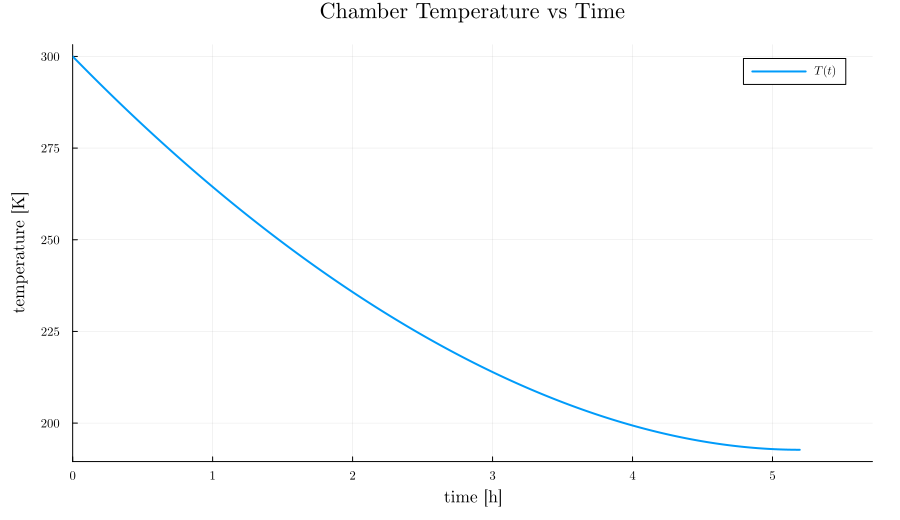

In [8]:
plot(t/3600, T, xlabel="time [h]", ylabel="temperature [K]", 
     title="Chamber Temperature vs Time", label=L"T(t)", 
     xlims=(0, ttarget/3600*1.1))

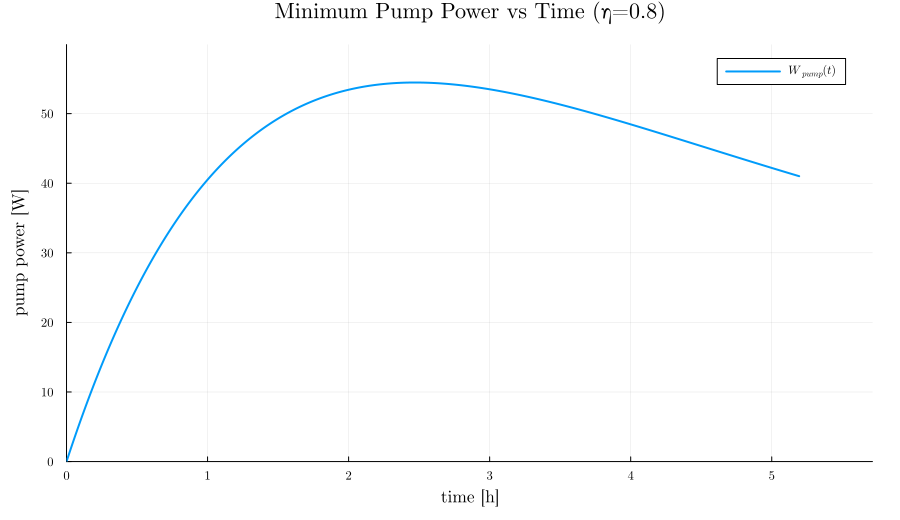

In [9]:
plot(t/3600, W, xlabel="time [h]", ylabel="pump power [W]", 
     title="Minimum Pump Power vs Time (η=$(η))", label=L"W_{pump}(t)", 
     xlims=(0, ttarget/3600*1.1), ylims=(0, maximum(W)*1.1))